In [1]:
%matplotlib inline
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeYorktown
import matplotlib.pyplot as plt

In [2]:
device_backend = FakeYorktown()
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates

In [3]:
#hyperparameters
th = [0 for i in range(8)]
shots = 8192
U = 4
mu = U/2
eps2 = 0
V = 0.745356

In [4]:
def fresh_circuit(theta):
    # Construct quantum circuit
    circ = QuantumCircuit(4, 4)
    circ.ry(theta[0],0)
    circ.ry(theta[1],1)
    circ.ry(theta[2],2)
    circ.ry(theta[3],3)
    circ.cx(0,1)
    circ.cx(1,2)
    circ.cx(2,3)
    circ.ry(theta[4],0)
    circ.ry(theta[5],1)
    circ.ry(theta[6],2)
    circ.ry(theta[7],3)
    return circ

In [13]:
def calc_H(th):
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend('qasm_simulator')
    circ_z = fresh_circuit(th)
    circ_z.measure(list(range(4)),list(range(4)))
    circ_x = fresh_circuit(th)
    circ_x.h([0,1,2,3])
    circ_x.measure(list(range(4)),list(range(4)))
    circ_y = fresh_circuit(th)
    circ_y.sdg([0,1,2,3])
    circ_y.h([0,1,2,3])
    circ_y.measure(list(range(4)),list(range(4)))
    # Execute noisy simulation and get counts
    result_noise = execute([circ_x, circ_y,circ_z], simulator,
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates,
                           shots=shots).result().get_counts()
    sigma = {'x': [sum([result_noise[0][key] for key in result_noise[0].keys() if key[i] == '0'])/shots for i in range(4)],
             'y': [sum([result_noise[1][key] for key in result_noise[1].keys() if key[i] == '0'])/shots for i in range(4)],
             'z': [sum([result_noise[2][key] for key in result_noise[2].keys() if key[i] == '0'])/shots for i in range(4)]}
    H1 = U*sigma['z'][0]*sigma['z'][2]/4 + (mu/2 - U/4)*(sigma['z'][0] + sigma['z'][2])
    H2 = eps2*(sigma['z'][1]+sigma['z'][3])/2
    H3 = V*(sigma['x'][0]*sigma['x'][1] + sigma['y'][0]*sigma['y'][1])/2
    H4 = V*(sigma['x'][2]*sigma['x'][3] + sigma['y'][2]*sigma['y'][3])/2
    H = H1-H2+H3+H4
    return H

In [36]:
H_th = list(map(lambda x: calc_H([0,0,0,0,0,0,0, x ]), np.linspace(-0.5, 0.5, 20)))

Text(0.5, 1.0, 'All other theta = 0')

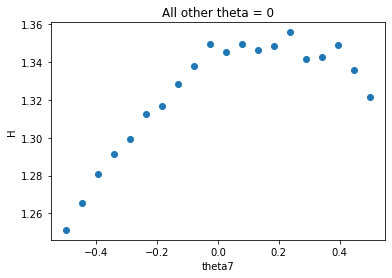

In [37]:
plt.scatter(np.linspace(-0.5, 0.5, 20), H_th)
plt.xlabel('theta7')
plt.ylabel('H')
plt.title('All other theta = 0')